Boston House Price Regression Practice
===
B036060017 資管四年級 謝威廷, 2018/3/25

## Import the dataset
- Fetch the Boston House Price dataset provided by scikit learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

dataset = load_boston()
boston = pd.DataFrame(dataset.data, columns = dataset.feature_names)
boston['target'] = dataset.target

boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Split the dataset to training set and test set

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(boston.iloc[:, :-1], boston.iloc[:, -1], 
                                                    test_size = 156,
                                                    random_state = 10,
                                                    shuffle = True)

print('Training : ', X_train.shape, ' Testing : ', X_test.shape)

Training :  (350, 13)  Testing :  (156, 13)


## Handcrafted - Ordinary Least Square Linear Regression (OLS)
- $fit (X,y)$ : Fit linear model
- $get\_Params()$ : Get parameters for this estimator
- $predict(X)$ : Predict using the linear model

In [173]:
class my_LR():
    
    def fit(self, X, y):
        """
        Fit the linear model
        
        Parameters:
        -----------
        X : a numpy array of form [num_samples, num_features]
        y : numpy array of form [num_samples, 1]
        
        """
        
        Xn = np.ndarray.copy(X)
        yn = np.ndarray.copy(y)

        X_mean = Xn.mean(axis=0)
        X_std = Xn.std(axis=0)
        X_std[X_std == 0] = 1
        self.X_mean = X_mean
        self.X_std = X_std
        
        # Normalization
        Xn = (Xn - X_mean) / X_std
        Xn = np.hstack((np.ones(X.shape[0])[np.newaxis].T, Xn))
        
        y_mean = yn.mean(axis=0)
        yn = yn - y_mean
        self.y_mean = y_mean

        # Return the least-squares solution to a linear matrix equation
        try:
            self.coef_, self.residuals_, self.rank_, self.singular_ = np.linalg.lstsq(Xn, yn)
        except Exception:
            print('Error occurred in Matrix operation.')
            raise
            
    def get_Params(self):
        """
        Return the regression coefficient for X
        """
        return self.coef_
    
    def predict(self, X):
        """
        Predict regression values for X
        """
        
        Xn = np.ndarray.copy(X)
        Xn = (Xn - self.X_mean) / self.X_std
        Xn = np.hstack((np.ones(X.shape[0])[np.newaxis].T, Xn))
        
        predict = np.dot(Xn, self.coef_) + self.y_mean
        
        return predict

### Fit the dataset to myLR

In [174]:
mylr = my_LR()
mylr.fit(X_train.values, y_train.values)

print(mylr.get_Params())

[  2.44927579e-14  -1.25528883e+00   1.60363151e+00  -1.29013135e-01
   3.81020979e-01  -1.76971793e+00   2.18611099e+00   3.06652188e-01
  -3.28355631e+00   2.71359659e+00  -2.14597384e+00  -1.74635139e+00
   1.24028529e+00  -3.84877355e+00]


## (A) List the three most key features that affect the price of houses
- Develop a Embedded Feature Selection method by using **Lasso Regression**
- Lasso Regularization makes it easier for the coefficients to be zero, and therefore easier to eliminate some of input variable as not contributing to the output, rather than Ridge Regularization tends to keep all the features.
- Last, the features selected by Lasso, could be seen as most key features among all features. 

<img src="https://i.imgur.com/13DcRYy.png" alt="Drawing" style="width: 400px;"/>

In [175]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

lassolr = LassoCV()
lasso_feature = SelectFromModel(lassolr, threshold=0.2)
lasso_feature.fit(X_train.values, y_train.values)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False),
        norm_order=1, prefit=False, threshold=0.2)

### Setup the number of features 
- The **top 3 key features** selected by Lasso are
    - RM : Average number of rooms per dwelling
    - DIS : Weighted distances to five Boston employment centres
    - LSTAT : % lower status of the population

In [191]:
n_features = lasso_feature.transform(X_train.values).shape[1]
while n_features > 3:
    lasso_feature.threshold += 0.1
    X_transform = lasso_feature.transform(X_train.values)
    n_features = X_transform.shape[1]
print("Number of feature selected : ", n_features)

print(dataset.DESCR)
print(boston.columns[:-1][lasso_feature.get_support()])

Number of feature selected :  3
Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

## (B) Try sklearn - linear regression to estimate the price

In [195]:
from sklearn.linear_model import LinearRegression, Lasso

sklr = LinearRegression()
sklr.fit(X_train, y_train)
sklr.predict(X_test.values)[:10]

array([ 31.4185429 ,  31.97039683,  30.98493102,  22.26928588,
        18.90712841,  16.15892513,  35.89835849,  14.78538014,
        25.10814431,  37.01575047])

## (C) Plot your estimated price, the price obtained from sklearn module vs actual price
- Due to there are 156 cases of test dataset, it's quite huge to plot all in one figure.
- Thus, plot first 10 cases to observe, you can adjust  $plot\_number$  to meet your own need.
- According to the plot, it seems there is **no big difference in estimated price** between our own LR model and sklearn LR model.

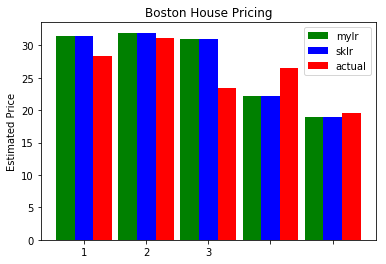

In [197]:
import matplotlib.pyplot as plt

plot_num = 5

idx = np.arange(1, actual_price.shape[0] + 1)[:plot_num]
mylr_price = mylr.predict(X_test.values)[:plot_num]
sklr_price = sklr.predict(X_test.values)[:plot_num]
actual_price = y_test.values[:plot_num]

width = 0.3

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(idx, mylr_price, width, color='g')
rects2 = ax.bar(idx + width, sklr_price, width, color='b')
rects3 = ax.bar(idx + width*2, actual_price, width, color='r')

ax.set_ylabel('Estimated Price')
ax.set_xticks(idx + width)
ax.set_xticklabels( ('1', '2', '3') )
ax.legend((rects1[0], rects2[0], rects3[0]), ('mylr', 'sklr', 'actual'))

plt.title('Boston House Pricing')
plt.show()

## (D) Try one different regression module provided by sklearn, and compare its result with ordinary linear regression approach.

- Using the **Lasso Regression with Cross Validated**.
- Proposed **MSE (Mean Squared Error)** to compare the prediction performance between LassoCV, and OLS.
- Surprisingly, our own OLS model outperform the LassoCV !

In [189]:
from sklearn.linear_model import LassoCV
sklassocv = LassoCV()
sklassocv.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [190]:
from sklearn.metrics import mean_squared_error

mylr_mse = mean_squared_error(y_test.values, mylr.predict(X_test.values))
print(mylr_mse)

lassocv_mse = mean_squared_error(y_test.values, sklassocv.predict(X_test.values))
print(lassocv_mse)

28.7605019584
35.6676265737
